In [1]:
import os
from glob import glob
import warnings

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio as rio
from rasterio.plot import *

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

#from shapely.geometry import box
warnings.simplefilter('ignore')

In [2]:
# Set working directory
working_dir = os.path.join(et.io.HOME, "desktop", "drought", "data")

# Switch to working directory
os.chdir(working_dir)

# Path to state data
state_path = os.path.join("TIGER", "cb_2018_us_state_500k.shp")

# Path to county data
county_path = os.path.join("TIGER", "cb_2018_us_county_500k.shp")

# Path to cities data
city_path = os.path.join("CA_dot_gov", "CA_Places_TIGER2016.shp")

# Path to roads data
roads_path = os.path.join("TIGER", "tl_2019_06_prisecroads.shp")

# Path to area of interest
aoi_path = os.path.join("created", "aoi.shp")

In [3]:
# Load state data into gdf
states = gpd.read_file(state_path)

# Select California area
ca = states[states.STUSPS == 'CA']

In [4]:
# Load county data into gdf
counties = gpd.read_file(county_path)

# Select Siskyou county
siskiyou = counties[counties.NAME == 'Siskiyou']

In [5]:
# Load cities
cities = gpd.read_file(city_path)

# Set to correct CRS
cities = cities.to_crs('EPSG:4269')

# Select relevant cities
cities = cities[cities.NAME.isin(['Yreka', 'San Francisco', 'Los Angeles', 'San Diego'])]

In [6]:
# Load major roads
roads = gpd.read_file(roads_path)

# Select only interstates
hwys = roads[roads.FULLNAME.str.contains('I-')]

In [7]:
# Create list of paths to landsat bands 1-9
landsat_paths = sorted(glob(os.path.join(working_dir, "landsat",
                                  "LC08_L1TP_045031_20200426_20200426_01_RT",
                                  "*B?.tif")))
# Set paths to R, G, B bands
rgb_paths = [landsat_paths[3], landsat_paths[2], landsat_paths[1]]

In [8]:
# Create output dir to hold cropped files
landsat_crop_dir = os.path.join(
    "landsat", "LC08_L1TP_045031_20200426_20200426_01_RT", "cropped")

# Load area of interest shapefile into gdf
aoi = gpd.read_file(aoi_path)

# Reproject aoi and siskiyou gdf into CRS of landsat scene
with rio.open(rgb_paths[0]) as src:
    aoi_reproj = aoi.to_crs(src.crs)
    siskiyou_reproj = siskiyou.to_crs(src.crs)

# Crop rasters in R, G, B list
es.crop_all(raster_paths=rgb_paths,
            output_dir=landsat_crop_dir,
            geoms=aoi_reproj,
            overwrite=True)

# Fetch cropped bands
landsat_cropped_bands = sorted(glob(os.path.join(landsat_crop_dir, "*B?_crop.tif")))

# Stack bands
landsat_stacked, landsat_stacked_meta = es.stack(landsat_cropped_bands, nodata=-9999)

# Get plotting extent
landsat_extent = plotting_extent(landsat_stacked[0], landsat_stacked_meta['transform'])

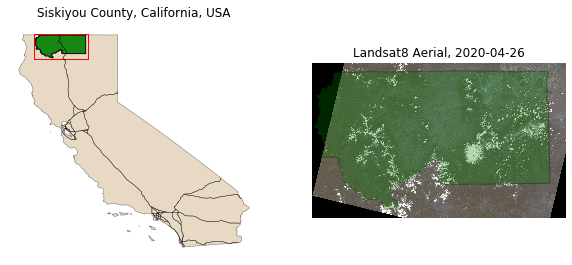

In [9]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(10,5))

"""Plot 1"""
# Set title
ax1.set(title="Siskiyou County, California, USA")

#cities.plot(ax=ax1, color='blue', zorder=3, label="City")

# Plot CA state boundaries
ca.plot(ax=ax1, color='tan', edgecolor='black', linewidth = 0.5, label="California", alpha=0.5)

# Plot county boundaries
siskiyou.plot(ax=ax1, color='green', edgecolor="black", alpha=0.9, label="Siskiyou County")

hwys.plot(ax=ax1, color='black', linewidth=0.3)

aoi.plot(ax=ax1, color="None", edgecolor="red")

# Turn off axis
ax1.set_axis_off()

"""Plot 2"""
ep.plot_rgb(landsat_stacked,
            rgb=[0, 1, 2],
            stretch=True,
            ax=ax2,
            title="Landsat8 Aerial, 2020-04-26",
           extent=landsat_extent)

siskiyou_reproj.plot(ax=ax2, color='green', 
                     edgecolor="black", alpha=0.3, 
                     label="Siskiyou County")

#aoi_reproj.plot(ax=ax2, color='None', edgecolor="red")

ax2.set_axis_off()

plt.show()